# TP de Graphe :
# 1.1 Construction du graphe

Arête ajoutée entre  (1, 0)  et  (0, 0)  avec coût  1.0
Arête ajoutée entre  (2, 0)  et  (1, 0)  avec coût  1.0
Arête ajoutée entre  (3, 0)  et  (2, 0)  avec coût  1.0
Arête ajoutée entre  (4, 0)  et  (3, 0)  avec coût  1.0
Arête ajoutée entre  (5, 0)  et  (4, 0)  avec coût  1.0
Arête ajoutée entre  (6, 0)  et  (5, 0)  avec coût  1.0
Arête ajoutée entre  (7, 0)  et  (6, 0)  avec coût  1.0
Arête ajoutée entre  (0, 1)  et  (0, 0)  avec coût  1.0
Arête ajoutée entre  (0, 1)  et  (1, 0)  avec coût  1.4142135623730951
Arête ajoutée entre  (2, 1)  et  (1, 0)  avec coût  1.4142135623730951
Arête ajoutée entre  (2, 1)  et  (2, 0)  avec coût  1.0
Arête ajoutée entre  (2, 1)  et  (3, 0)  avec coût  1.4142135623730951
Arête ajoutée entre  (3, 1)  et  (2, 0)  avec coût  1.4142135623730951
Arête ajoutée entre  (3, 1)  et  (2, 1)  avec coût  1.0
Arête ajoutée entre  (3, 1)  et  (3, 0)  avec coût  1.0
Arête ajoutée entre  (3, 1)  et  (4, 0)  avec coût  1.4142135623730951
Arête ajoutée entre  (4, 1)  

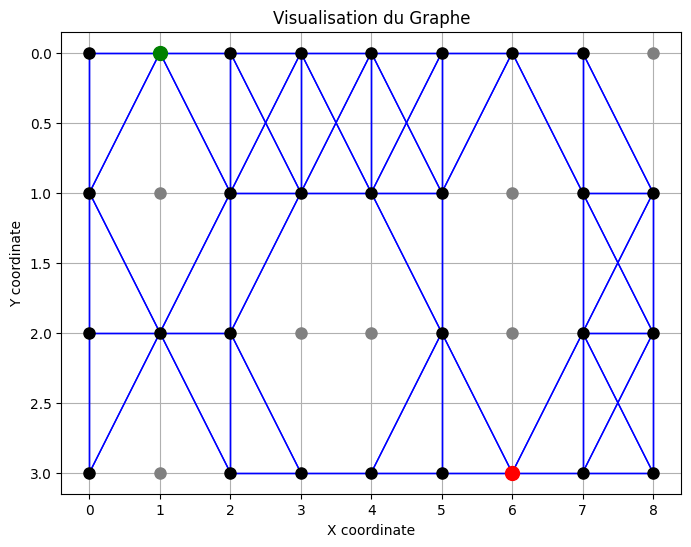

In [34]:
import matplotlib.pyplot as plt
import math

class Graphe:
    def __init__(self):
        self.graphe = {}
        self.depart = None
        self.arrivee = None
        self.couts = {}
        self.non_connectables = set()
        self.matrice = []

    def ajouter_sommet(self, sommet):
        x, y = sommet
        if y < len(self.matrice) and x < len(self.matrice[y]):
            connectable = self.matrice[y][x] != '0'
            if sommet not in self.graphe:
                self.graphe[sommet] = set()
                if not connectable:
                    self.non_connectables.add(sommet)
            # Connecter aux sommets adjacents
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    if dx != 0 or dy != 0:
                        nx, ny = x + dx, y + dy
                        if 0 <= nx < len(self.matrice[0]) and 0 <= ny < len(self.matrice):
                            if self.matrice[ny][nx] != '0' and self.matrice[y][x] != '0':
                                voisin = (nx, ny)
                                cout = math.sqrt(dx*dx + dy*dy)
                                if voisin in self.graphe:
                                    self.ajouter_arete(sommet, voisin, cout)

    def ajouter_arete(self, u, v, cout):
        if u in self.graphe and v in self.graphe and u not in self.non_connectables and v not in self.non_connectables:
            self.graphe[u].add(v)
            self.graphe[v].add(u)
            self.couts[(u, v)] = self.couts[(v, u)] = cout
            print("Arête ajoutée entre ", u, " et ", v, " avec coût ", cout)


    def ajouter_sommet_manuelle(self, sommet, valeur):
        x, y = sommet
        # Étendre la matrice si nécessaire
        while y >= len(self.matrice):
            self.matrice.append(['0'] * len(self.matrice[0]))  # Ajouter une nouvelle ligne pleine de '0'
        while x >= len(self.matrice[y]):
            for ligne in self.matrice:
                ligne.append('0')  # Ajouter un '0' à la fin de chaque ligne existante pour étendre les colonnes

        # Mettre à jour la matrice avec la valeur spécifiée
        self.matrice[y][x] = valeur

        # Vérifier si le sommet est un point de départ ou d'arrivée et si ces points existent déjà
        if valeur == '2' and self.depart is not None:
            print("Un point de départ existe déjà.")
            return
        if valeur == '3' and self.arrivee is not None:
            print("Un point d'arrivée existe déjà.")
            return

        # Définir le départ ou l'arrivée si applicable
        if valeur == '2':
            self.depart = sommet
        if valeur == '3':
            self.arrivee = sommet

        # Ajouter le sommet au graphe s'il est connectable
        connectable = valeur != '0'
        if sommet not in self.graphe:
            self.graphe[sommet] = set()
            if not connectable:
                self.non_connectables.add(sommet)

    def supprimer_sommet(self, sommet):
        if sommet not in self.graphe:
            print("Sommet non trouvé dans le graphe.")
            return

        # Supprimer toutes les arêtes associées au sommet
        voisins = list(self.graphe[sommet])  # Créer une liste des voisins pour éviter la modification pendant l'itération
        for v in voisins:
            self.supprimer_arete(sommet, v)

        # Supprimer le sommet du graphe et des non connectables
        self.graphe.pop(sommet)
        self.non_connectables.discard(sommet)

        # Gérer le départ et l'arrivée
        if sommet == self.depart:
            self.depart = None
        if sommet == self.arrivee:
            self.arrivee = None

        # Supprimer le sommet de la matrice
        x, y = sommet
        self.matrice[y][x] = '0'

        # Vérifier si la ligne entière est vide
        if all(value == '0' for value in self.matrice[y]):
            del self.matrice[y]  # Supprimer la ligne entièrement vide

        # Vérifier si la colonne entière est vide
        if all(self.matrice[i][x] == '0' for i in range(len(self.matrice))):
            for ligne in self.matrice:
                del ligne[x]  # Supprimer la colonne entièrement vide

        print("Sommet ",sommet," et toutes ses connexions supprimés.")
    
    def supprimer_arete(self, u, v):
        if u in self.graphe and v in self.graphe:
            self.graphe[u].discard(v)
            self.graphe[v].discard(u)

    def creer_graphe_depuis_fichier(self, chemin_fichier):
        with open(chemin_fichier, 'r') as fichier:
            lignes = fichier.readlines()

        n, m = map(int, lignes[0].split())
        self.matrice = [ligne.strip().split() for ligne in lignes[1:n+1]]

        for y in range(n):
            for x in range(m):
                self.ajouter_sommet((x, y))
                if self.matrice[y][x] == '2':
                    self.depart = (x, y)
                elif self.matrice[y][x] == '3':
                    self.arrivee = (x, y)

    def afficher_matrice(self):
        for ligne in self.matrice:
            print(' '.join(ligne))

    def tracer_graphe(self):
        plt.figure(figsize=(8, 6))
        for u in self.graphe:
            for v in self.graphe[u]:
                plt.plot([u[0], v[0]], [u[1], v[1]], 'b-', linewidth=1)
        for u in self.graphe:
            color = 'grey' if u in self.non_connectables else 'black'
            plt.plot(u[0], u[1], 'o', color=color, markersize=8)
        if self.depart:
            plt.plot(self.depart[0], self.depart[1], 'go', markersize=10)
        if self.arrivee:
            plt.plot(self.arrivee[0], self.arrivee[1], 'ro', markersize=10)
        plt.xlabel('X coordinate')
        plt.ylabel('Y coordinate')
        plt.title('Visualisation du Graphe')
        plt.gca().invert_yaxis()
        plt.grid(True)
        plt.show()

# Utilisation
graphe = Graphe()
graphe.creer_graphe_depuis_fichier('exo1.txt')  # Assurez-vous que le chemin d'accès est correct
graphe.afficher_matrice()
graphe.tracer_graphe()

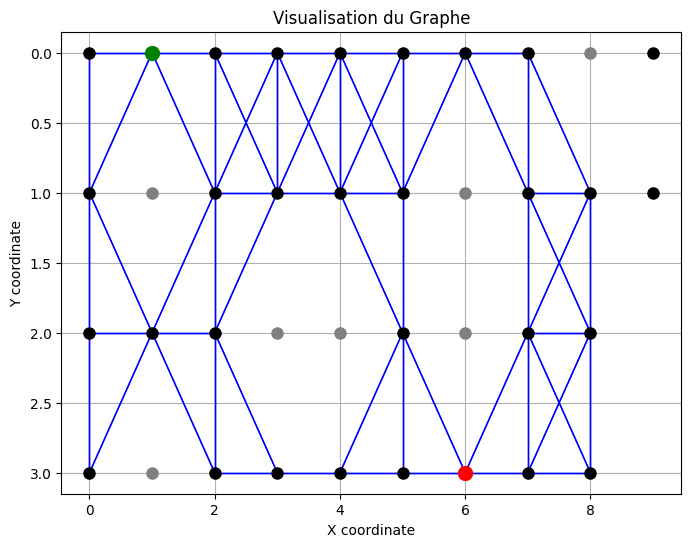

In [35]:
graphe.ajouter_sommet_manuelle((9,0),1)
graphe.ajouter_sommet_manuelle((9,1),1)
graphe.tracer_graphe()

Sommet  (9, 0)  et toutes ses connexions supprimés.


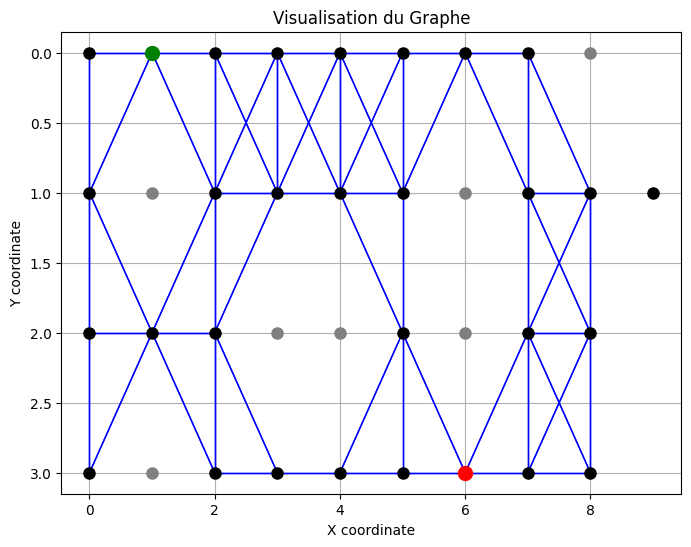

In [36]:
graphe.supprimer_sommet((9,0))
graphe.tracer_graphe()

Sommet  (9, 1)  et toutes ses connexions supprimés.


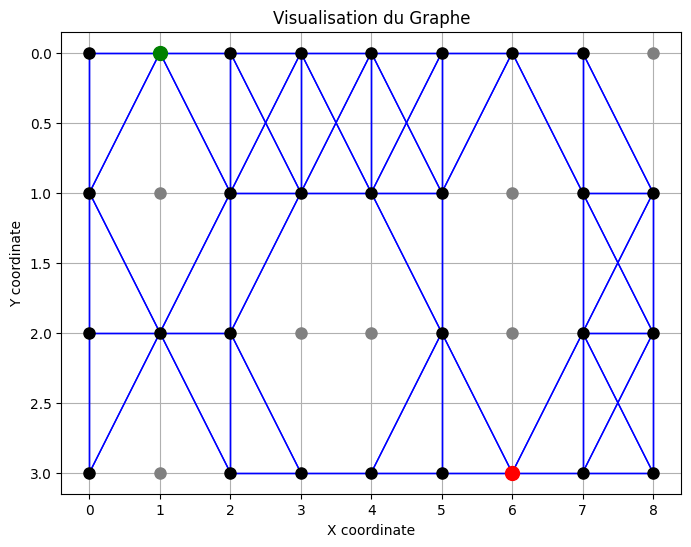

In [37]:
graphe.supprimer_sommet((9,1))
graphe.tracer_graphe()

# 1.2 Modélisation mathématique

## Modélisation du Problème en Programmation Linéaire

Le problème du plus court chemin dans un graphe peut être formulé comme un problème de programmation linéaire. Ce problème consiste à trouver le chemin le moins coûteux entre une source et une destination dans un graphe.

### Variables
Pour chaque arête $(u, v)$ dans le graphe, nous définissons une variable binaire $x_{uv}$ qui indique si l'arête $(u, v)$ est utilisée dans le chemin le plus court.

### Fonction Objectif
La fonction objectif est de minimiser le coût total du chemin. Cela est exprimé comme suit :

$$ \min \sum_{(u, v) \in E} c_{uv} x_{uv} $$

où $c_{uv}$ représente le coût de l'arête $(u, v)$.

### Contraintes

#### Conservation du Flux
Pour chaque sommet $v$ autre que la source $s$ et la destination $t$, la conservation du flux doit être respectée :

$$ \sum_{(u, v) \in E} x_{uv} - \sum_{(v, w) \in E} x_{vw} = 0 $$

#### Contraintes de la Source et de la Destination
La source $s$ doit avoir exactement une arête sortante active et la destination $t$ doit avoir exactement une arête entrante active :

- Pour la source $s$ :
$$ \sum_{(s, v) \in E} x_{sv} = 1 $$

- Pour la destination $t$ :
$$ \sum_{(u, t) \in E} x_{ut} = 1 $$

## Résumé
Cette modélisation permet de transformer le problème du plus court chemin en un problème de programmation linéaire, où la solution optimale indique le chemin le plus court en termes de coût entre deux points donnés dans un réseau.


## Implémentation avec CPLEX

In [38]:
import datetime

def save_results_to_file(graphe, filename):
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)

    # Ajouter les variables
    vars = []
    for (u, v), cout in graphe.couts.items():
        varname = f"x_{u}_{v}"
        vars.append(varname)
        cpx.variables.add(names=[varname], obj=[cout], types=["B"])

    # Ajouter les contraintes de conservation de flux
    for node in graphe.graphe.keys():
        edges_in = [f"x_{u}_{v}" for (u, v) in graphe.couts.keys() if v == node]
        edges_out = [f"x_{u}_{v}" for (u, v) in graphe.couts.keys() if u == node]
        row = [1.0] * len(edges_in) + [-1.0] * len(edges_out)
        cpx.linear_constraints.add(
            lin_expr=[cplex.SparsePair(ind=edges_in + edges_out, val=row)],
            senses=["E"],
            rhs=[0]
        )

    # Spécifier les contraintes pour la source et la destination
    start_edges = [f"x_{graphe.depart}_{v}" for v in graphe.graphe[graphe.depart]]
    cpx.linear_constraints.add(lin_expr=[[start_edges, [1]*len(start_edges)]], senses=["E"], rhs=[1])

    end_edges = [f"x_{u}_{graphe.arrivee}" for u in graphe.graphe[graphe.arrivee]]
    cpx.linear_constraints.add(lin_expr=[[end_edges, [1]*len(end_edges)]], senses=["E"], rhs=[1])

    cpx.solve()

    # Créer un nom de fichier avec date et heure
    now = datetime.datetime.now()
    date_time = now.strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"{filename}_{date_time}.txt"

    # Ouvrir le fichier et écrire les résultats
    with open(filename, 'w') as file:
        file.write(f"Solution status = {cpx.solution.get_status()}\n")
        file.write(f"Solution value = {cpx.solution.get_objective_value()}\n")
        values = cpx.solution.get_values()
        for var, value in zip(vars, values):
            if value > 0.5:
                file.write(f"{var} = {value}\n")
        file.write("Path taken:\n")
        for var, value in zip(vars, values):
            if value > 0.5:
                u, v = var[2:].split("_")
                file.write(f"{u} to {v}\n")

    print(f"Results saved to {filename}")

# Usage
graphe = Graphe()
graphe.creer_graphe_depuis_fichier('exo1.txt')
save_results_to_file(graphe, "resultat")


Arête ajoutée entre  (1, 0)  et  (0, 0)  avec coût  1.0
Arête ajoutée entre  (2, 0)  et  (1, 0)  avec coût  1.0
Arête ajoutée entre  (3, 0)  et  (2, 0)  avec coût  1.0
Arête ajoutée entre  (4, 0)  et  (3, 0)  avec coût  1.0
Arête ajoutée entre  (5, 0)  et  (4, 0)  avec coût  1.0
Arête ajoutée entre  (6, 0)  et  (5, 0)  avec coût  1.0
Arête ajoutée entre  (7, 0)  et  (6, 0)  avec coût  1.0
Arête ajoutée entre  (0, 1)  et  (0, 0)  avec coût  1.0
Arête ajoutée entre  (0, 1)  et  (1, 0)  avec coût  1.4142135623730951
Arête ajoutée entre  (2, 1)  et  (1, 0)  avec coût  1.4142135623730951
Arête ajoutée entre  (2, 1)  et  (2, 0)  avec coût  1.0
Arête ajoutée entre  (2, 1)  et  (3, 0)  avec coût  1.4142135623730951
Arête ajoutée entre  (3, 1)  et  (2, 0)  avec coût  1.4142135623730951
Arête ajoutée entre  (3, 1)  et  (2, 1)  avec coût  1.0
Arête ajoutée entre  (3, 1)  et  (3, 0)  avec coût  1.0
Arête ajoutée entre  (3, 1)  et  (4, 0)  avec coût  1.4142135623730951
Arête ajoutée entre  (4, 1)  